# Diabetes Prediction Project

# Problem Statement

Diabetes is a chronic condition that affects millions of people worldwide, and early detection is critical for preventing severe health complications. In this project, the goal is to develop a machine learning model that accurately predicts whether a patient has diabetes based on various health indicators. Given the severe consequences of undiagnosed diabetes, the model's primary focus is on **maximizing recall** to minimize false negatives, i.e., ensuring that as many diabetic patients as possible are correctly identified.

The challenge lies in balancing high recall with acceptable precision to avoid an excessive number of false positives, which could lead to unnecessary medical interventions and patient anxiety. The dataset used contains imbalanced class distribution, with a much higher proportion of non-diabetic patients, adding further complexity to the task.

Through this project, various machine learning algorithms will be evaluated, including Decision Trees and XGBoost, with hyperparameter tuning performed using Optuna to optimize the model's performance. The objective is to develop a robust prediction model suitable for use in a healthcare setting, where early and accurate diabetes detection is essential.

### **Importing Libraries**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from plotly.io import show
import plotly.io as pio
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv(r'diabetes_prediction_dataset.csv')

In [6]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [7]:
data.shape

(100000, 9)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


### **Feature Engineering**

In [9]:
# check null values
data.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [10]:
# drop duplicates if any
data.drop_duplicates(inplace=True)

In [11]:
# nunique values
data.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

In [12]:
data['gender'].value_counts()

Female    56161
Male      39967
Other        18
Name: gender, dtype: int64

In [13]:
# removing other category
data = data[data['gender'] != 'Other']
data['gender'].value_counts()

Female    56161
Male      39967
Name: gender, dtype: int64

In [14]:
# descriptive statstics
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000
mean,41.796617,0.077615,0.040810,27.321450,5.532633,138.218001,0.088237
std,22.463329,0.267567,0.197851,6.767811,1.073225,40.911190,0.283640
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [15]:
# fixing smoking_history colm
data['smoking_history'].value_counts()

never          34395
No Info        32881
former          9299
current         9197
not current     6359
ever            3997
Name: smoking_history, dtype: int64

In [16]:
data['smoking_history'] = data['smoking_history'].replace({'never':'non-smoker', 'ever':'past-smoker',
                                                           'former':'past-smoker', 'not current':'past-smoker'})
data['smoking_history'].value_counts()

non-smoker     34395
No Info        32881
past-smoker    19655
current         9197
Name: smoking_history, dtype: int64

In [17]:
# Calculate total counts for categories excluding 'No Info'
df_excluding_no_info = data[data['smoking_history'] != 'No Info']
total_excluding_no_info = df_excluding_no_info['smoking_history'].value_counts().sum()

# Calculate the proportion of each category excluding 'No Info'
proportions = df_excluding_no_info['smoking_history'].value_counts(normalize=True)

# Get the count of 'No Info'
no_info_count = data[data['smoking_history'] == 'No Info'].shape[0]

# Distribute 'No Info' based on these proportions
distributed_no_info = proportions * no_info_count

# Create a new column 'smoking_history_final' to include the distributed 'No Info'
data['smoking_history_final'] = data['smoking_history']

# Distribute the 'No Info' proportionally into the other categories
for category in distributed_no_info.index:
    mask = data['smoking_history'] == 'No Info'
    count_to_distribute = int(distributed_no_info[category])

    # Update 'No Info' rows with the distributed category
    data.loc[mask, 'smoking_history_final'] = data.loc[mask, 'smoking_history_final'].replace('No Info', category, limit=count_to_distribute)

# Check the updated 'smoking_history_final' column
print(data['smoking_history_final'].value_counts())

non-smoker     67276
past-smoker    19655
current         9197
Name: smoking_history_final, dtype: int64


In [18]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_final
0,Female,80.0,0,1,non-smoker,25.19,6.6,140,0,non-smoker
1,Female,54.0,0,0,No Info,27.32,6.6,80,0,non-smoker
2,Male,28.0,0,0,non-smoker,27.32,5.7,158,0,non-smoker
3,Female,36.0,0,0,current,23.45,5.0,155,0,current
4,Male,76.0,1,1,current,20.14,4.8,155,0,current


## **EDA**

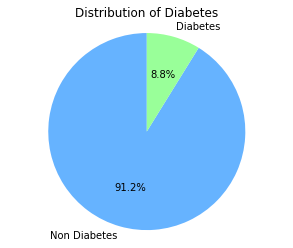

In [19]:
#We do Map 1 to 'Diabetes' and 0 to 'Non Diabetes'
diabetes_mapped = data['diabetes'].map({1: 'Diabetes', 0: 'Non Diabetes'})
#Counting the occurrences of each category
diabetes_counts = diabetes_mapped.value_counts()
#Now plotting the piechart
plt.figure(figsize=(5,4))
plt.pie(diabetes_counts, labels=diabetes_counts.index, autopct='%1.1f%%',startangle=90, colors=['#66b3ff','#99ff99'])
plt.title('Distribution of Diabetes')
plt.axis('equal')
plt.show()

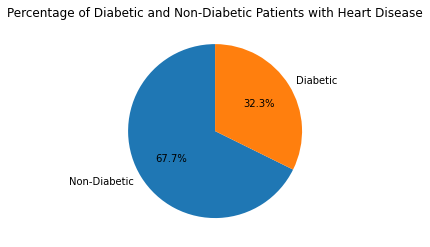

In [20]:
#pie chart shows percent of diabetic vs non diabetic with heart diease
heart_disease_diabetes_counts = data[data['heart_disease'] == 1].groupby('diabetes')['diabetes'].count()
plt.figure(figsize=(5,4))
plt.pie(heart_disease_diabetes_counts, labels=['Non-Diabetic', 'Diabetic'], autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Diabetic and Non-Diabetic Patients with Heart Disease')
plt.show()

We see that 32.4% are diabetic with heart disease,without filtering on heart disease 8.5% of them are diabetic.
So people with heart disease are around 4% more likely to get diabetes
This shows predicting power of heart disease,it is important feature.

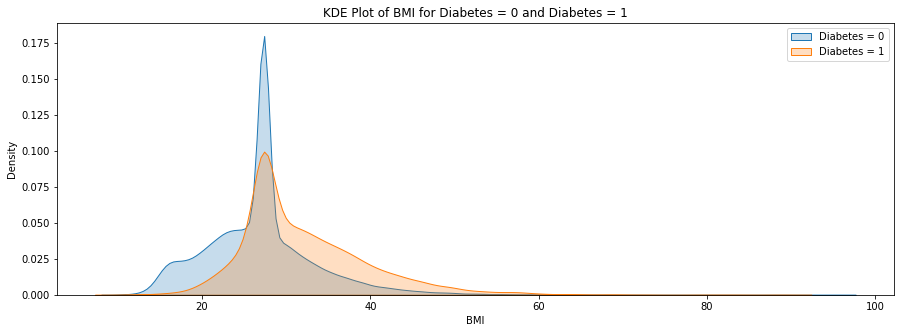

In [21]:
#kde plot of with and without diabetes
plt.figure(figsize= (15,5))
sns.kdeplot(data[data['diabetes'] == 0]['bmi'], label='Diabetes = 0',shade=True)
sns.kdeplot(data[data['diabetes'] == 1]['bmi'],label='Diabetes = 1', shade=True)
plt.xlabel('BMI')
plt.ylabel('Density')
plt.title('KDE Plot of BMI for Diabetes = 0 and Diabetes = 1')
plt.legend()
plt.show()

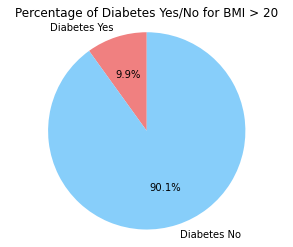

In [22]:
bmi_over_20_data = data[data['bmi'] > 20]
#filtered above 20 bmi rows
#Now finding the number of people with diabetes and without diabetes in the filtered data,after above line
diabetes_yes_count = len(bmi_over_20_data[bmi_over_20_data['diabetes'] == 1])
diabetes_no_count = len(bmi_over_20_data[bmi_over_20_data['diabetes'] == 0])
#Finding perecentages of Y/N
diabetes_yes_percentage = (diabetes_yes_count / len(bmi_over_20_data)) * 100
diabetes_no_percentage = (diabetes_no_count / len(bmi_over_20_data)) * 100
labels = ['Diabetes Yes', 'Diabetes No']
sizes = [diabetes_yes_percentage, diabetes_no_percentage]
colors = ['lightcoral','lightskyblue']
#plot pie chart
plt.figure(figsize=(5,4))
plt.pie(sizes, labels=labels,colors=colors,autopct='%1.1f%%',startangle=90)
plt.axis('equal')
plt.title('Percentage of Diabetes Yes/No for BMI > 20')
plt.show()

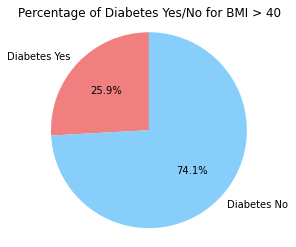

In [23]:
# Filtering the  data for bmi > 40 rows
bmi_over_40_data = data[data['bmi'] > 40]
# Now calculate the number of people with diabetes and without diabetes in the filtered data
diabetes_yes_count = len(bmi_over_40_data[bmi_over_40_data['diabetes'] == 1])
diabetes_no_count = len(bmi_over_40_data[bmi_over_40_data['diabetes'] == 0])
diabetes_yes_percentage = (diabetes_yes_count / len(bmi_over_40_data)) * 100#then finding % OF y/n
diabetes_no_percentage = (diabetes_no_count / len(bmi_over_40_data)) * 100

# Create a pie chart
labels = ['Diabetes Yes', 'Diabetes No']
sizes = [diabetes_yes_percentage, diabetes_no_percentage]
colors = ['lightcoral', 'lightskyblue']

#plotting pie chart
plt.figure(figsize=(5,4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Percentage of Diabetes Yes/No for BMI > 40')
plt.show()

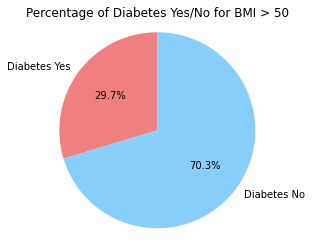

In [24]:
# Filter data for bmi > 50
bmi_over_50_data = data[data['bmi'] > 50]

#Now calculate the number of people with diabetes and without diabetes in the filtered data
diabetes_yes_count = len(bmi_over_50_data[bmi_over_50_data['diabetes'] == 1])
diabetes_no_count = len(bmi_over_50_data[bmi_over_50_data['diabetes'] == 0])
#Finding perecentages of Y/N
diabetes_yes_percentage = (diabetes_yes_count / len(bmi_over_50_data)) * 100 if len(bmi_over_50_data) > 0 else 0
diabetes_no_percentage = (diabetes_no_count / len(bmi_over_50_data)) * 100 if len(bmi_over_50_data) > 0 else 0

# Now to plot pie chart
plt.figure(figsize=(5,4))
labels = ['Diabetes Yes', 'Diabetes No']
sizes = [diabetes_yes_percentage, diabetes_no_percentage]
colors = ['lightcoral', 'lightskyblue']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Percentage of Diabetes Yes/No for BMI > 50')
plt.show()

So the above 3 piecharts shows as bmi increases,the person becomes more prone to diabetes

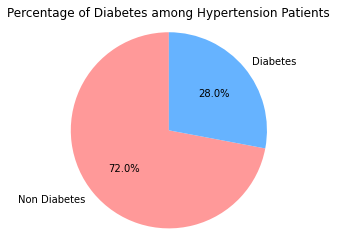

In [25]:
#At first filter the rows where hypertension is present
hypertension_data = data[data['hypertension'] == 1]

#now to find % of people with/without diabetes in hypertensed people
hypertension_diabetes_percentage = hypertension_data['diabetes'].value_counts(normalize=True)*100
hypertension_diabetes_percentage.index = hypertension_diabetes_percentage.index.map({1:'Diabetes',0:'Non Diabetes'})

#Plotting the pie charrt
plt.figure(figsize=(5,4))
plt.pie(hypertension_diabetes_percentage, labels=hypertension_diabetes_percentage.index,autopct='%1.1f%%',startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Percentage of Diabetes among Hypertension Patients')
plt.axis('equal')
plt.show()

We see that 28% are diabetic with hypertension,without filtering on hypertension 8.5% of them are diabetic.
So people with heart hypertension are 3.3% more likely to get diabetes
This shows predicting power of heart disease,it is important feature.

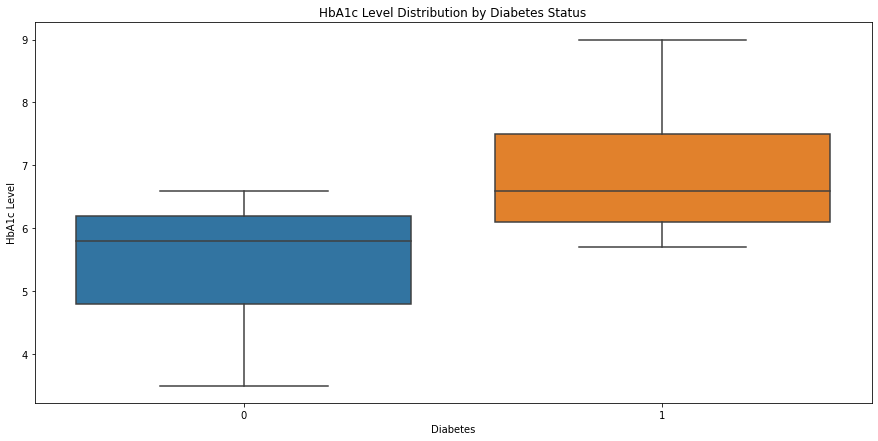

In [26]:
#HbA1c_level variable boxplot with hue is diabetes
plt.figure(figsize=(15, 7))
sns.boxplot(x='diabetes', y='HbA1c_level', data=data)
plt.xlabel('Diabetes')
plt.ylabel('HbA1c Level')
plt.title('HbA1c Level Distribution by Diabetes Status')
plt.show()

Hba1c is a good feature in predicting Diabetes because increased Hba1c increases risk of Diabetes

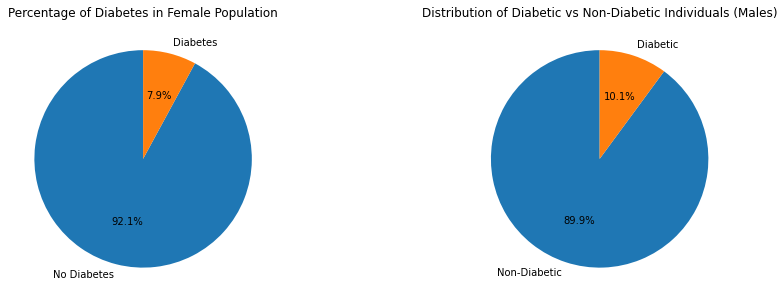

In [27]:
#Pie chart of diabetes in females
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
female_data = data[data['gender'] == 'Female']
diabetes_counts = female_data['diabetes'].value_counts()
plt.pie(diabetes_counts, labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Diabetes in Female Population')

#pie chart of percentage diabetes in men
plt.subplot(1,2,2)
male_diabetes_counts = data[data['gender'] == 'Male']['diabetes'].value_counts()
plt.pie(male_diabetes_counts, labels=['Non-Diabetic', 'Diabetic'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Diabetic vs Non-Diabetic Individuals (Males)')
plt.show()

Men have 2% higher chance to get Diabetes than Females.Note that only 8% had diabetes in overall population.
Men are at a little more risk.

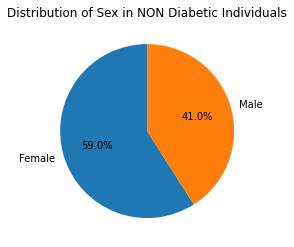

In [28]:
diabetic_data = data[data['diabetes'] == 0]
sex_counts = diabetic_data['gender'].value_counts()
plt.figure(figsize=(5,4))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Sex in NON Diabetic Individuals')
plt.show()

In non diabetes 2/3 of population(majority) is Females

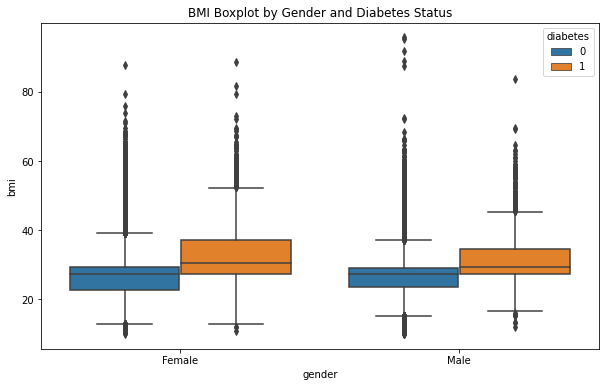

In [29]:
#par plots of bmi showing diabetes yes or no
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='bmi', hue='diabetes', data=data)
plt.title('BMI Boxplot by Gender and Diabetes Status')
plt.show()

Diabetic patients have higher BMI irrespective of Sex.
Females bmi is spread more than Males.In non diabetic their Quartiles being almost same.But in diabetic patient,females BMI is higher than male Q3.

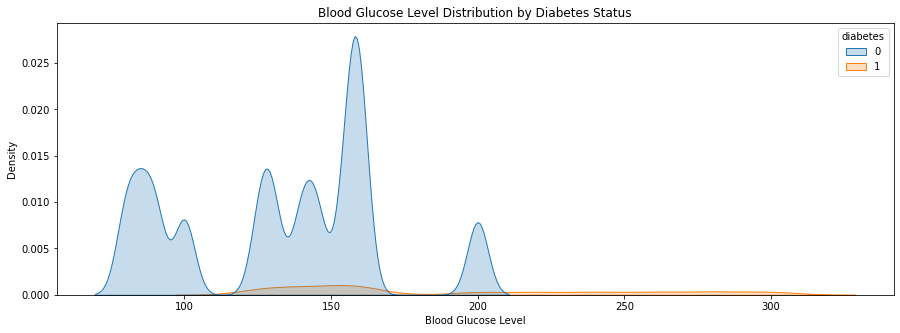

In [30]:
#blood_glucose_level	kde plot,with hue is diabetes
plt.figure(figsize=(15, 5))
sns.kdeplot(data=data, x='blood_glucose_level',hue='diabetes', fill=True)
plt.title('Blood Glucose Level Distribution by Diabetes Status')
plt.xlabel('Blood Glucose Level')
plt.ylabel('Density')
plt.show()

look at the only pink curve
1) If a person has 210 around Blood Glucose Level,then he/she will definately have diabetes,
   if person has less than around 100 blood glucose level,definelty no diabtes
   looking at the blue graph
1) If person has less than around 100 blood glucose level,definelty no diabetes
2) It is surpsrising to see that there are people around 200,who don't have diabetes

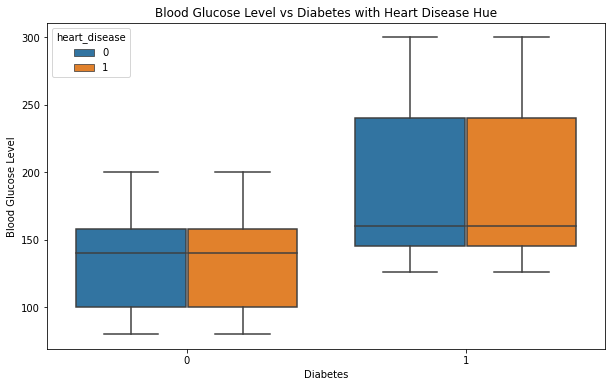

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='diabetes', y='blood_glucose_level', hue='heart_disease', data=data)
plt.title('Blood Glucose Level vs Diabetes with Heart Disease Hue')
plt.xlabel('Diabetes')
plt.ylabel('Blood Glucose Level')
plt.show()

1) blood glucose level inreases both risk of both heart disease and diabetes Equally
2) we see that third quartile of diabetes present is same as q1 of diabetes absent,showing instensity of glucose level affecting   both heart disease and diabetes to increase

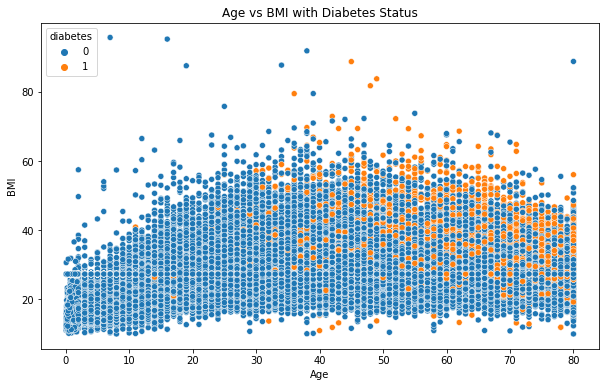

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=data)
plt.title('Age vs BMI with Diabetes Status')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.show()

There is no such relation between age and obesity.

In [33]:
median_age_by_diabetes = data.groupby('diabetes')['age'].median()
print(median_age_by_diabetes)

diabetes
0    40.0
1    62.0
Name: age, dtype: float64


Older people having higher risk of diabetes compared to young people

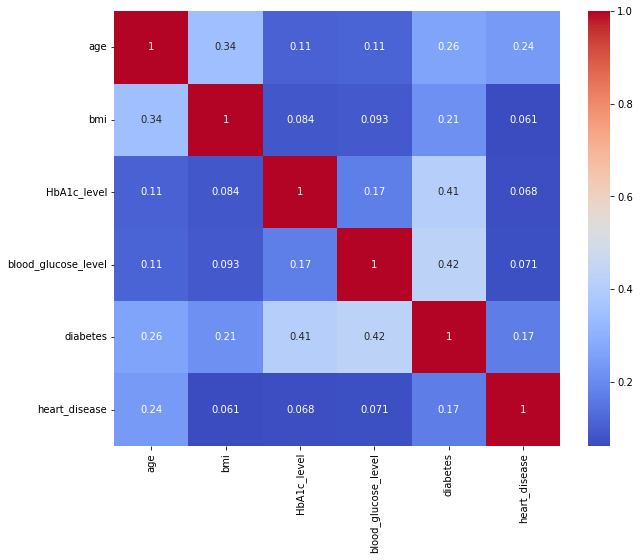

In [34]:
# heatmap
num_col = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','diabetes','heart_disease']
plt.figure(figsize=(10, 8))
sns.heatmap(data[num_col].corr(),annot=True, cmap='coolwarm')
plt.show()

### **Model Preparation**

In [35]:
# feature and target
X = data.drop('diabetes', axis=1)
y = data['diabetes']

In [36]:
# train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=47)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=47)

In [37]:
# Check the imbalance in the target variable
diabetes_distribution = y.value_counts()
diabetes_distribution

0    87646
1     8482
Name: diabetes, dtype: int64

In [38]:
# numerical colms
num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','heart_disease']
num_pip = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [39]:
# categorical colms
cat_cols = ['hypertension', 'smoking_history']
cat_pip = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [40]:
# transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pip, num_cols),
    ('cat', cat_pip, cat_cols)
])

In [41]:
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.45)

# pipeline
clf = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

In [42]:
# Define models to tune and compare
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'KNeighbors': KNeighborsClassifier(),
    'SVM': SVC(random_state=42)
}

In [43]:
# Hyperparameter grids
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'LogisticRegression': {
        'classifier__C': [0.1, 1, 10]
    },
    'DecisionTree': {
        'classifier__max_depth': [5, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
        },
    'KNeighbors': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
        },
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
}


In [45]:
best_model = None
best_recall = 0

for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    param_grid = param_grids.get(name, {})

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    y_pred = grid_search.predict(X_test)

    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"Model: {name}")
    print(f"Best Params: {grid_search.best_params_}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)
    print(f"Recall: {recall:.2f}\n")

    if recall > best_recall:
        best_recall = recall
        best_model = name

print(f"Best Model: {best_model} with Recall: {best_recall:.2f}")


Model: RandomForest
Best Params: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Confusion Matrix:
[[8744   59]
 [ 245  565]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8803
           1       0.91      0.70      0.79       810

    accuracy                           0.97      9613
   macro avg       0.94      0.85      0.89      9613
weighted avg       0.97      0.97      0.97      9613

Recall: 0.70

Model: LogisticRegression
Best Params: {'classifier__C': 10}
Confusion Matrix:
[[8731   72]
 [ 296  514]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      8803
           1       0.88      0.63      0.74       810

    accuracy                           0.96      9613
   macro avg       0.92      0.81      0.86      9613
weighted avg       0.

The best model is DecisionTree with Recall of 0.74

In [44]:
data = pd.get_dummies(data, columns=['gender', 'smoking_history_final'], drop_first=True)

# Training XGBoost and using Optuna for Tuning

In [45]:
X = data.drop(['diabetes','smoking_history'], axis=1)
y = data['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    param = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
        "eta": trial.suggest_float("eta", 0.01, 0.3),  # learning rate
        "gamma": trial.suggest_float("gamma", 0, 5),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),  # handle class imbalance
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }

    model = xgb.XGBClassifier(**param, use_label_encoder=False)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Compute recall (as we are focusing on detecting diabetic patients)
    recall = recall_score(y_test, y_pred)
    return recall

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

print("Best trial:")
trial = study.best_trial
print(f"  Recall: {trial.value}")
print("  Best hyperparameters: ", trial.params)

best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False)
final_model.fit(X_train, y_train)

y_pred_final = final_model.predict(X_test)
final_recall = recall_score(y_test, y_pred_final)
print(f"Final recall: {final_recall}")


Best trial:
  Recall: 0.927689594356261
  Best hyperparameters:  {'lambda': 2.6507471620659225e-06, 'alpha': 0.0004965952991603463, 'eta': 0.01086173001880838, 'gamma': 0.6012566015325183, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6525766275191912, 'colsample_bytree': 0.9963942464370643, 'scale_pos_weight': 9.996295804183568, 'n_estimators': 518}
Final recall: 0.927689594356261


Final Model has Recall Score of 0.927

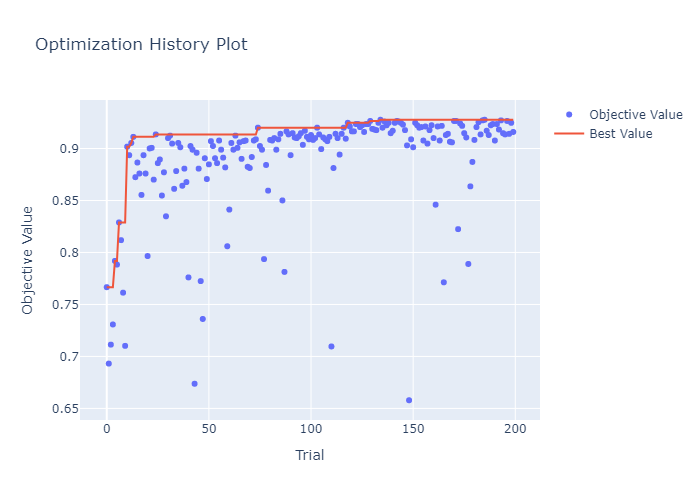

In [46]:
fig = optuna.visualization.plot_optimization_history(study)
pio.write_image(fig, 'plot.png')
from IPython.display import Image
Image('plot.png')

We can see a gradual increase in objective value as number of trials increase

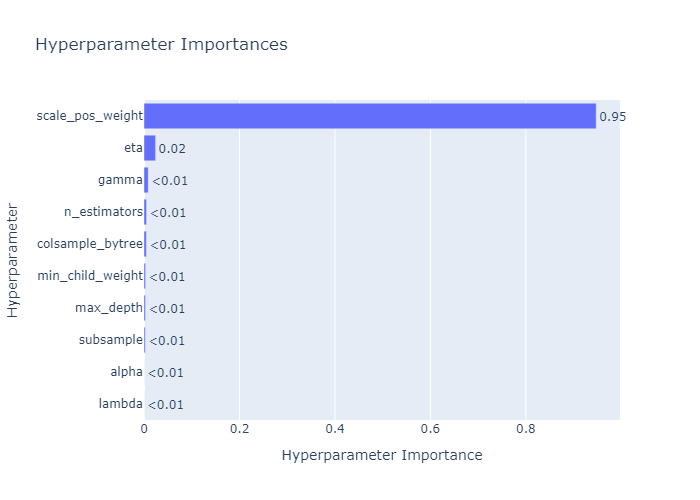

In [47]:
figure = optuna.visualization.plot_param_importances(study)
pio.write_image(figure, 'plot1.png')
Image('plot1.png')

We can see that Hyperparameter 'scale_pos_weight' has very high importance in maximizing objective function (Recall)

Model Accuracy:  0.8983147820659524
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     17525
           1       0.46      0.93      0.62      1701

    accuracy                           0.90     19226
   macro avg       0.73      0.91      0.78     19226
weighted avg       0.95      0.90      0.91     19226



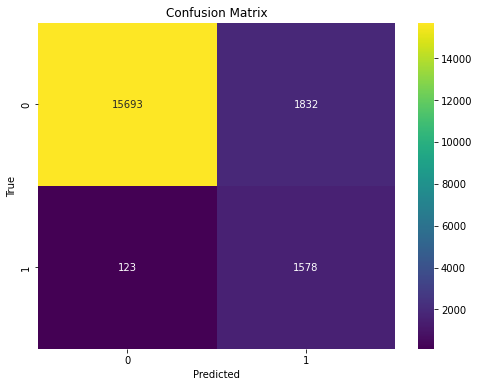

In [48]:
print("Model Accuracy: ", accuracy_score(y_test, y_pred_final))
print(classification_report(y_test, y_pred_final))
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Final Model has following Evaluation Metrics:
1. Recall - 0.93
2. Precision - 0.46
3. F1 Score - 0.62
4. Accuracy - 0.89

As Recall Metric is our highest priority, Model can correctly predict around 93% of All Diabetic Patients. But there are some False Positives as well because Precision is 0.46

This is a tradeoff we are willing to make because correctly predicting diabetic patients is our highest priority

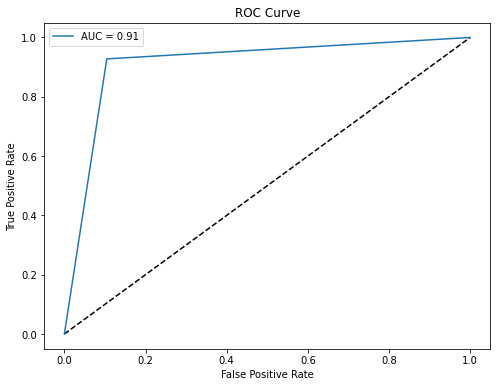

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

From the ROC curve shown, the AUC (Area Under the Curve) is 0.91, indicating that the model performs well at distinguishing between the positive and negative classes. A higher AUC value (closer to 1) represents better model performance. In this case, the model has a strong ability to classify true positives while maintaining a relatively low false positive rate, making it a good model for the given classification task.

# Conclusion

In the development of diabetes prediction model, We experimented with multiple algorithms to maximize recall, which was critical due to the need to accurately identify diabetic patients. Initially, using a Decision Tree classifier, the model achieved a recall of 0.74. While this was a reasonable result, it indicated that 26% of diabetic cases were still being missed, highlighting the need for further improvement.

We then applied XGBoost, a more advanced and powerful gradient boosting algorithm, and fine-tuned its hyperparameters using Optuna. This approach yielded significant improvement, with the recall increasing to 0.93, meaning the model now correctly identifies 93% of diabetic patients. However, this improvement in recall came at the cost of precision, which dropped to 0.4. This suggests that while the model is better at detecting diabetes, it also produces more false positives, where non-diabetic individuals are incorrectly classified as diabetic.

In conclusion, the tuned XGBoost model offers a strong ability to detect diabetic patients (high recall), making it a suitable choice for cases where minimizing missed diagnoses is crucial. However, further work could be done to balance recall and precision to reduce the number of false positives and improve the model's overall reliability in a real-world healthcare setting.